In [44]:
import kinpy as kp
import numpy as np
from numpy.linalg import inv
from scipy.spatial.transform import Rotation as R
from PIL import Image
import cv2
import json
from torchvision.utils import draw_keypoints
from torchvision.transforms.functional import to_pil_image, to_tensor
import numpy as np
import torch

In [3]:
# download `iiwa.zip` from https://rutgers.box.com/s/c53lo0jaqy24gp4x0djw3r91usmejvu0 and unzip it.
# this zip file contains the URDF for a Kuka robot arm, a demo image, and some joint values
chain = kp.build_chain_from_urdf(open("./iiwa/kuka.urdf").read())

Unknown tag "material" in /robot[@name='iiwa14']/link[@name='iiwa_link_0']/collision[1]
Unknown tag "self_collision_checking" in /robot[@name='iiwa14']/link[@name='iiwa_link_0']
Unknown tag "material" in /robot[@name='iiwa14']/link[@name='iiwa_link_1']/collision[1]
Unknown tag "material" in /robot[@name='iiwa14']/link[@name='iiwa_link_2']/collision[1]
Unknown tag "material" in /robot[@name='iiwa14']/link[@name='iiwa_link_3']/collision[1]
Unknown tag "material" in /robot[@name='iiwa14']/link[@name='iiwa_link_4']/collision[1]
Unknown tag "material" in /robot[@name='iiwa14']/link[@name='iiwa_link_5']/collision[1]
Unknown tag "material" in /robot[@name='iiwa14']/link[@name='iiwa_link_6']/collision[1]
Unknown tag "material" in /robot[@name='iiwa14']/link[@name='iiwa_link_7']/collision[1]
Unknown tag "material" in /robot[@name='iiwa14']/link[@name='finger_1_link_0']/collision[1]
Unknown tag "material" in /robot[@name='iiwa14']/link[@name='finger_1_link_1']/collision[1]
Unknown tag "material"

In [4]:
chain.get_joint_parameter_names() 

['iiwa_joint_1',
 'iiwa_joint_2',
 'iiwa_joint_3',
 'iiwa_joint_4',
 'iiwa_joint_5',
 'iiwa_joint_6',
 'iiwa_joint_7',
 'palm_finger_1_joint',
 'finger_1_joint_1',
 'finger_1_joint_2',
 'finger_1_joint_3',
 'palm_finger_2_joint',
 'finger_2_joint_1',
 'finger_2_joint_2',
 'finger_2_joint_3',
 'finger_middle_joint_1',
 'finger_middle_joint_2',
 'finger_middle_joint_3']

In [5]:
# from camera calibration
intrinsics = np.array([[616.992431640625, 0, 314.10406494140625], 
                       [0, 616.95458984375, 236.41192626953125], 
                       [0, 0, 1]])

extrinsics = np.array(
    [[-9.999587495896877787e-01, 4.816601804160051264e-03, -7.700614656528768573e-03, 5.137678522942569215e-01], 
 [-5.611898425792972642e-03, 3.390012510461920536e-01, 9.407691844364246547e-01, -1.352227898374197324e+00],
 [7.141828553442494329e-03, 9.407735923888260743e-01, -3.389602368254073794e-01, 8.079596512727922342e-01],
 [0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 1.000000000000000000e+00]])

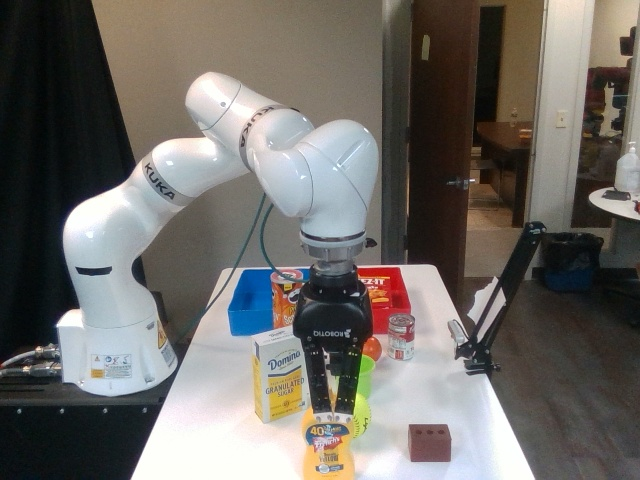

In [24]:
joint_values = json.load(open("iiwa/demo.joints.json"))
fig = Image.open('iiwa/demo.png')
img = np.array(fig)
fig

In [13]:
jv = [joint_values.get(a, 0) for a in chain.get_joint_parameter_names()]
links = chain.forward_kinematics(jv, end_only=False)
link_names = list(links.keys())
links

{'world': Transform(rot=[1. 0. 0. 0.], pos=[0. 0. 0.]),
 'iiwa_link_0': Transform(rot=[1. 0. 0. 0.], pos=[0. 0. 0.]),
 'iiwa_link_1': Transform(rot=[ 0.994   0.      0.     -0.1093], pos=[0.     0.     0.1575]),
 'iiwa_link_2': Transform(rot=[-0.2348  0.3741  0.6     0.667 ], pos=[0.   0.   0.36]),
 'iiwa_link_3': Transform(rot=[-0.7452  0.1601 -0.4025  0.5071], pos=[ 0.1559 -0.0347  0.4878]),
 'iiwa_link_4': Transform(rot=[-0.206  -0.3907 -0.1548  0.8837], pos=[ 0.3201 -0.0712  0.6224]),
 'iiwa_link_5': Transform(rot=[-0.3337 -0.6412  0.3809 -0.5765], pos=[ 0.4096 -0.2313  0.6016]),
 'iiwa_link_6': Transform(rot=[ 0.6146 -0.6049  0.3585 -0.3576], pos=[ 0.5141 -0.4181  0.5774]),
 'iiwa_link_7': Transform(rot=[ 0.0035 -0.0859  0.9963  0.006 ], pos=[ 0.5146 -0.4171  0.4964]),
 'iiwa_link_ee': Transform(rot=[ 0.0035 -0.0859  0.9963  0.006 ], pos=[ 0.515  -0.4163  0.4264]),
 'palm': Transform(rot=[-0.5157  0.5125  0.4902 -0.4807], pos=[ 0.5156 -0.4151  0.3314]),
 'finger_1_link_0': Transfo

In [60]:
points_2d, _ = cv2.projectPoints(np.array([links[k].pos for k in link_names]).reshape(-1, 3),  
                            inv(extrinsics)[:3, :3], inv(extrinsics)[:3, -1], intrinsics, None)

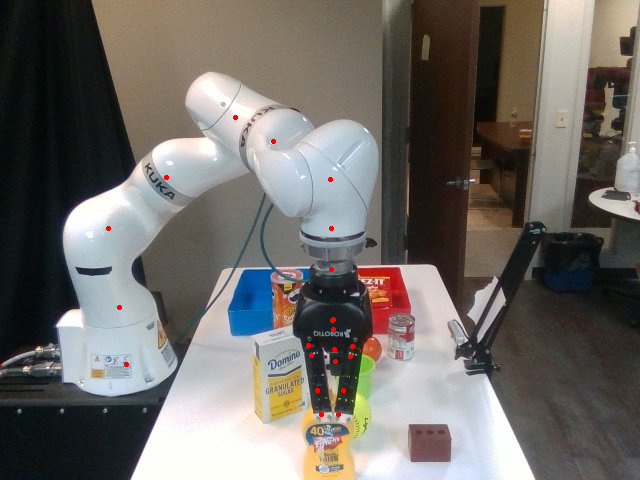

In [63]:
to_pil_image(draw_keypoints(torch.from_numpy(img).permute(2, 0, 1), torch.from_numpy(points_2d),
                            colors='red')).rotate(angle=180) # rotate since the original camera is installed upside down